# Task

Operators like joins, selections and missing value imputaters can cause *data distribution issues*, which can heavily impact the performance of our model for specific demographic groups. Mlinspect helps with identifying such issues by offering a check that calculates histograms for sensitive groups in the data and verifying whether the histogram change is significant enough to alert the user. Thanks to our annotation propagation, we can deal with complex code involving things like nested sklearn pipelines and group memberships that are removed from the training data using projections.

We want to find out if preprocessing operations in pipelines introduce bias and if so, which groups are effected.
The pipeline we want to analyse in this task can be found using the path `os.path.join(str(get_project_root()), "experiments", "user_interviews", "adult_simple_modified.py")`. The senstive attributes we want to take a look at are `race` and `sex`. 

It is using a benchmark dataset frequently used in the algorithmic fairness literature. `Adult income` contains information about 33,000 individuals from the 1994 U.S. census, with sensitive attributes gender and race. The corresponding task is to predict whether the annual income of an individual exceeds $50,000. We took this existing data set and only modified it slightly by introducing an artificial issue which we will now try to find using mlinspect.


The code of the pipeline:
> ```python
> """
> Adult income pipeline
> """
> import os
> import pandas as pd
> from sklearn import compose, preprocessing, tree, pipeline
> 
> from mlinspect.utils import get_project_root
> 
> print('pipeline start')
> 
> train_file_a = os.path.join(str(get_project_root()), "experiments", "user_interviews", "adult_simple_train_a.csv")
> raw_data_a = pd.read_csv(train_file_a, na_values='?', index_col=0)
> 
> train_file_b = os.path.join(str(get_project_root()), "experiments", "user_interviews", "adult_simple_train_b.csv")
> raw_data_b = pd.read_csv(train_file_b, na_values='?', index_col=0)
> 
> merged_raw_data = raw_data_a.merge(raw_data_b, on="id")
> 
> data = merged_raw_data.dropna()
> 
> labels = preprocessing.label_binarize(data['income-per-year'], classes=['>50K', '<=50K'])
> 
> column_transformer = compose.ColumnTransformer(transformers=[
>     ('categorical', preprocessing.OneHotEncoder(handle_unknown='ignore'), ['education', 'workclass']),
>     ('numeric', preprocessing.StandardScaler(), ['age', 'hours-per-week'])
> ])
> adult_income_pipeline = pipeline.Pipeline([
>     ('features', column_transformer),
>     ('classifier', tree.DecisionTreeClassifier())])
> 
> adult_income_pipeline.fit(data, labels)
> print('pipeline finished')
> ```

# Step 1/4: Add check and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `.py` file. 

First, we define the check we want mlinspect to run. In this example, we only use `NoBiasIntroducedFor(["col1", "col2", ...])` to automatically check for significant changes in the distribution of sensitive demograhpic groups and compute the histograms.

Then, we execute the pipeline. Mlinspect returns a `InspectorResult`, which, among other information, contains the output of our check. 

In [1]:
import os
from mlinspect.utils import get_project_root

from mlinspect import PipelineInspector
from mlinspect.checks import NoBiasIntroducedFor
from mlinspect.inspections import HistogramForColumns, IntersectionalLabelHistogramForColumns, RowLineage

from example_pipelines import ADULT_DEMO_PY

inspector_result = PipelineInspector\
    .on_pipeline_from_py_file(ADULT_DEMO_PY) \
    .add_check(NoBiasIntroducedFor(["race", "sex"])) \
    .add_required_inspection(IntersectionalLabelHistogramForColumns(['marital-status'], 'income-per-year')) \
    .add_required_inspection(IntersectionalLabelHistogramForColumns(['race'], 'income-per-year')) \
    .add_required_inspection(RowLineage(5)) \
    .execute()

check_results = inspector_result.check_to_check_results
extracted_dag = inspector_result.dag

0.7440737489025461
0.8746387565414356


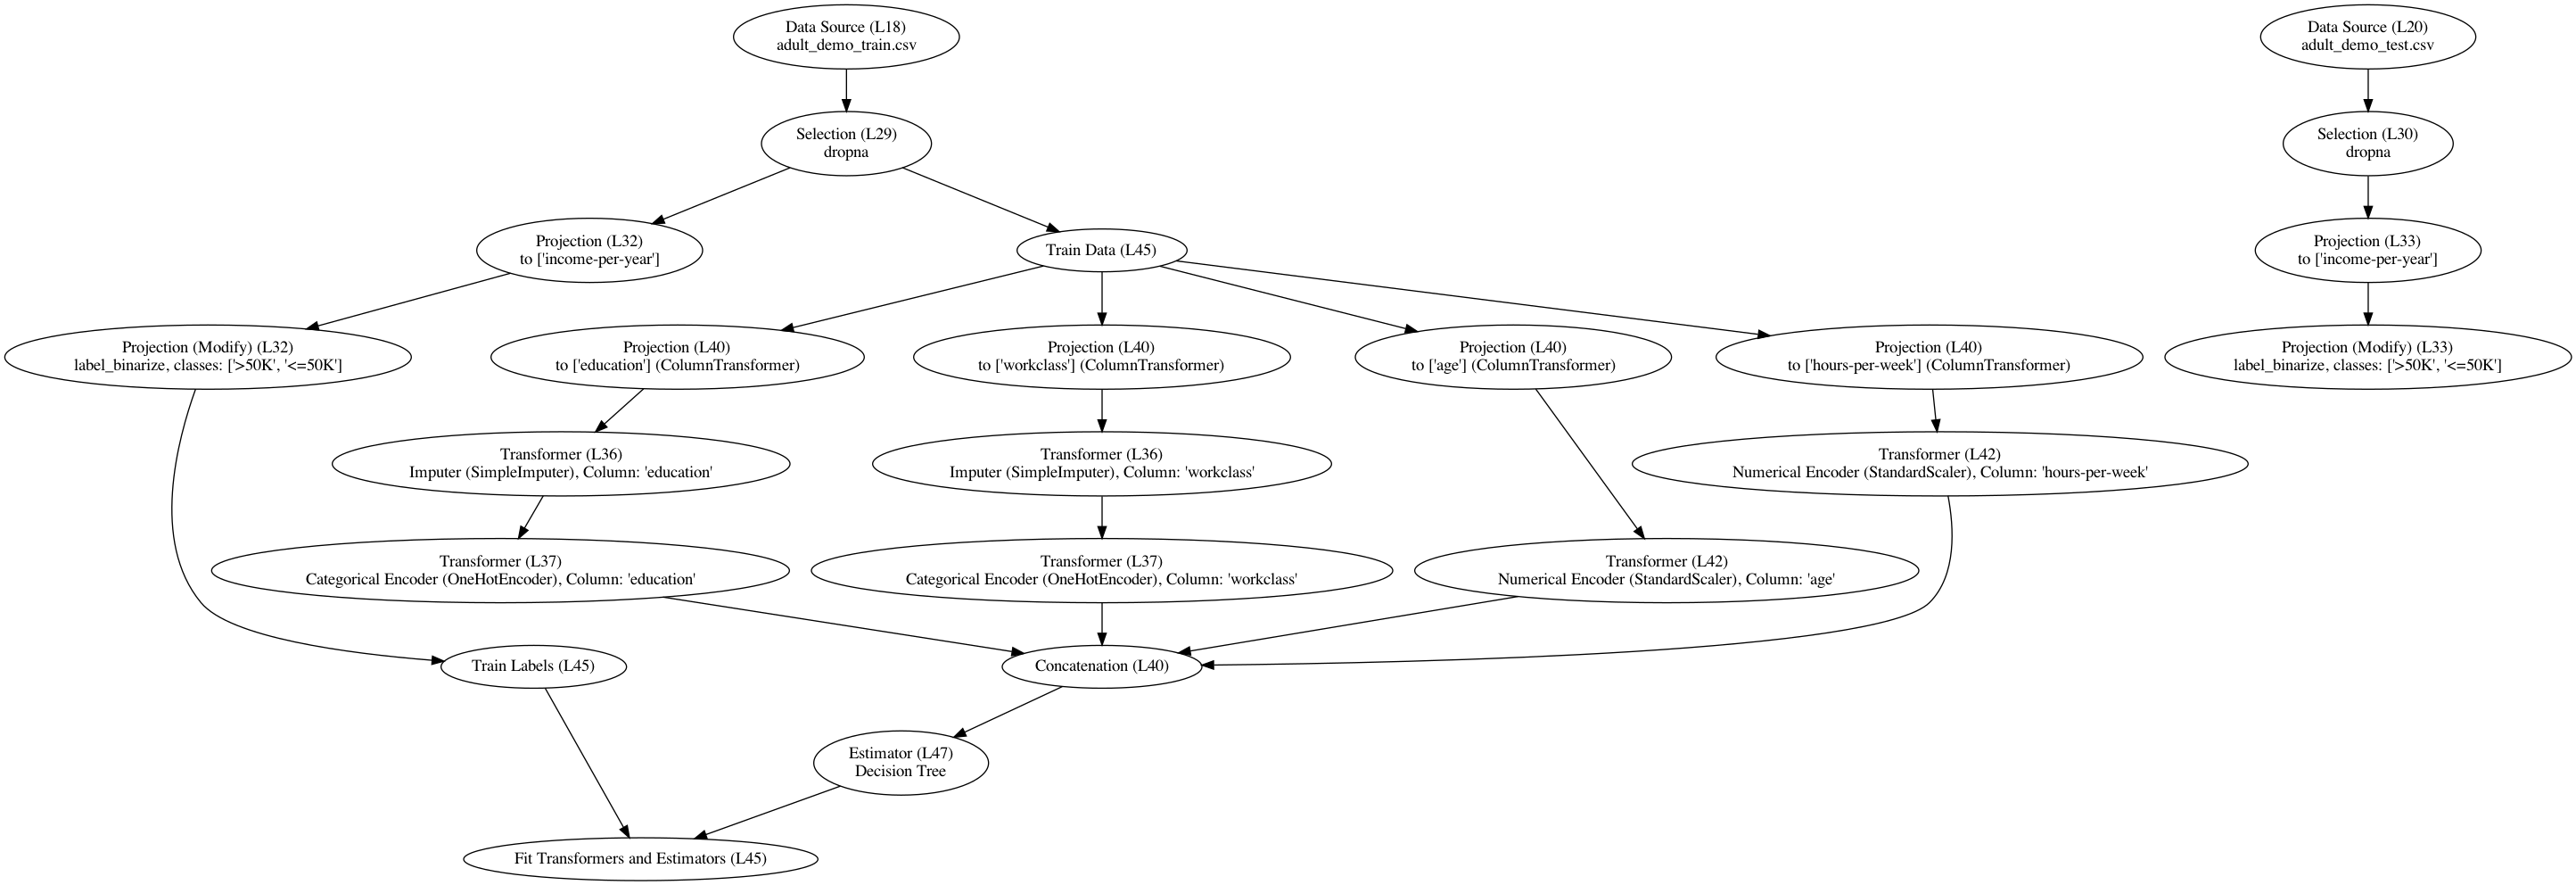

In [2]:
from IPython.display import Image
from mlinspect.visualisation import save_fig_to_path

filename = os.path.join(str(get_project_root()), "demo", "feature_overview", "adult-demo.png")
save_fig_to_path(extracted_dag, filename)

Image(filename=filename)

# Step 2/4: Overview of the check results
## Did our check find issues?

Let us look at the `check_result` to see our some check failed. We do this using the mlinspect utlity function `check_results_as_data_frame(...)`. We see that an issue was found, so we have to investigate it.

In [3]:
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

check_result_df = PipelineInspector.check_results_as_data_frame(check_results)
display(check_result_df)

,check_name,status,description
0,"NoBiasIntroducedFor((('race', 'sex'), -0.3, 2.0))",CheckStatus.FAILURE,"A Selection causes a max_probability_difference of 'race' by 2.0953281827342964, a value above the configured maximum threshold 2.0! A Selection causes a max_probability_difference of 'race' by 2.705426356589147, a value above the configured maximum threshold 2.0!"


# Step 3/4: List of operations that could change the distribution 

As stated before, only some operations like selections, joins and missing value imputation can change the distribution. Our check already filtered all operators that can cause data distribution issues. We can use the mlinspect utility function `get_distribution_changes_overview_as_df(...)` to get an overview. The overview already tells us that mlinspect detected a potential issue caused by a JOIN involving the gender attribute. Note that the automatic issue detection from mlinspect is only as good as its configuration and should not be completely relied upon.

In [4]:
from matplotlib import pyplot
import collections
import copy

node_histograms = inspector_result.inspection_to_annotations[IntersectionalLabelHistogramForColumns(['marital-status'], 'income-per-year')]
node_histograms = list(node_histograms.items())

all_records = copy.deepcopy(node_histograms[0][1])
complete = copy.deepcopy(node_histograms[2][1])

incomplete = copy.deepcopy(node_histograms[0][1]) # We now calculate this
for label, complete_histogram in complete.items():
    incomplete_histogram = incomplete[label]
    for group, count in complete_histogram.items():
        incomplete_histogram[group] -= count

print("All records")
print(all_records)
print("Incomplete records")
print(incomplete)
print("Complete records")
print(complete)

print("Incomplete records")
sum_incomplete_values = 0
for index, label_with_histogram in enumerate(incomplete.items()):
    histogram = label_with_histogram[1]
    values = histogram.values()
    sum_incomplete_values += sum(values)
print(sum_incomplete_values)

print("Complete records")
sum_complete_values = 0
for index, label_with_histogram in enumerate(complete.items()):
    histogram = label_with_histogram[1]
    values = histogram.values()
    sum_complete_values += sum(values)
print(sum_complete_values)

All records
{'>50K': {('Never-married',): 409, ('Married-civ-spouse',): 5646, ('Divorced',): 382, ('Separated',): 58, ('Widowed',): 72, ('Married-spouse-absent',): 27, ('Married-AF-spouse',): 9}, '<=50K': {('Married-civ-spouse',): 7058, ('Never-married',): 8691, ('Divorced',): 3386, ('Separated',): 818, ('Widowed',): 778, ('Married-spouse-absent',): 331, ('Married-AF-spouse',): 11}}
Incomplete records
{'>50K': {('Never-married',): 18, ('Married-civ-spouse',): 240, ('Divorced',): 10, ('Separated',): 0, ('Widowed',): 4, ('Married-spouse-absent',): 3, ('Married-AF-spouse',): 0}, '<=50K': {('Married-civ-spouse',): 546, ('Never-married',): 808, ('Divorced',): 184, ('Separated',): 72, ('Widowed',): 143, ('Married-spouse-absent',): 40, ('Married-AF-spouse',): 2}}
Complete records
{'>50K': {('Never-married',): 391, ('Married-civ-spouse',): 5406, ('Divorced',): 372, ('Separated',): 58, ('Widowed',): 68, ('Married-spouse-absent',): 24, ('Married-AF-spouse',): 9}, '<=50K': {('Married-civ-spouse',

Group counts
Incomplete


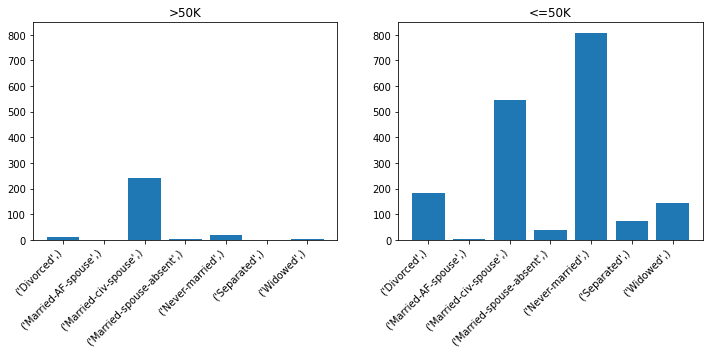

Complete


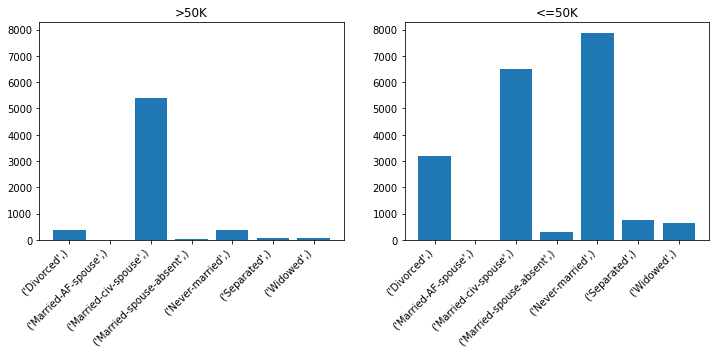

In [5]:
print("Group counts")

print("Incomplete")
label_with_histogram = list(incomplete.items())[0]
label = label_with_histogram[0]
histogram = label_with_histogram[1]
histogram = collections.OrderedDict(sorted(histogram.items()))
ax1 = pyplot.subplot(1, 2, 1)
keys = [str(key) for key in histogram.keys()] # Necessary because of null values
values = histogram.values()
# values = [value / sum_incomplete_values for value in values]
pyplot.bar(keys, values)
pyplot.gca().set_title(label)
pyplot.xticks(
    rotation=45,
    horizontalalignment='right',
)
# pyplot.yscale('log')

label_with_histogram = list(incomplete.items())[1]
label = label_with_histogram[0]
histogram = label_with_histogram[1]
histogram = collections.OrderedDict(sorted(histogram.items()))
ax2 = pyplot.subplot(1, 2, 2, sharey=ax1)
keys = [str(key) for key in histogram.keys()] # Necessary because of null values
values = histogram.values()
# values = [value / sum_incomplete_values for value in values]
pyplot.bar(keys, values)
pyplot.gca().set_title(label)
pyplot.xticks(
    rotation=45,
    horizontalalignment='right',
)
# pyplot.yscale('log')
fig = pyplot.gcf()
fig.set_size_inches(12, 4)
pyplot.show()
pyplot.close()


print("Complete")
label_with_histogram = list(complete.items())[0]
label = label_with_histogram[0]
histogram = label_with_histogram[1]
histogram = collections.OrderedDict(sorted(histogram.items()))
ax1 = pyplot.subplot(1, 2, 1)
keys = [str(key) for key in histogram.keys()] # Necessary because of null values
values = histogram.values()
#values = [value / sum_complete_values for value in values]
pyplot.bar(keys, values)
pyplot.gca().set_title(label)
pyplot.xticks(
    rotation=45,
    horizontalalignment='right',
)
#pyplot.yscale('log')

label_with_histogram = list(complete.items())[1]
label = label_with_histogram[0]
histogram = label_with_histogram[1]
histogram = collections.OrderedDict(sorted(histogram.items()))
ax2 = pyplot.subplot(1, 2, 2, sharey=ax1)
keys = [str(key) for key in histogram.keys()] # Necessary because of null values
values = histogram.values()
#values = [value / sum_complete_values for value in values]
pyplot.bar(keys, values)
pyplot.gca().set_title(label)
pyplot.xticks(
    rotation=45,
    horizontalalignment='right',
)
#pyplot.yscale('log')
                             
fig = pyplot.gcf()
fig.set_size_inches(12, 4)
pyplot.show()
pyplot.close()

In [6]:
from matplotlib import pyplot
import collections
import copy

node_histograms = inspector_result.inspection_to_annotations[IntersectionalLabelHistogramForColumns(['race'], 'income-per-year')]
node_histograms = list(node_histograms.items())

all_records = copy.deepcopy(node_histograms[0][1])
complete = copy.deepcopy(node_histograms[2][1])

incomplete = copy.deepcopy(node_histograms[0][1]) # We now calculate this
for label, complete_histogram in complete.items():
    incomplete_histogram = incomplete[label]
    for group, count in complete_histogram.items():
        incomplete_histogram[group] -= count

print("All records")
print(all_records)
print("Incomplete records")
print(incomplete)
print("Complete records")
print(complete)

print("Incomplete records")
sum_incomplete_values = 0
for index, label_with_histogram in enumerate(incomplete.items()):
    histogram = label_with_histogram[1]
    values = histogram.values()
    sum_incomplete_values += sum(values)
print(sum_incomplete_values)

print("Complete records")
sum_complete_values = 0
for index, label_with_histogram in enumerate(complete.items()):
    histogram = label_with_histogram[1]
    values = histogram.values()
    sum_complete_values += sum(values)
print(sum_complete_values)

All records
{'>50K': {('White',): 5991, ('Asian-Pac-Islander',): 234, ('Black',): 326, ('Amer-Indian-Eskimo',): 31, ('Other',): 21}, '<=50K': {('White',): 17637, ('Black',): 2334, ('Other',): 208, ('Asian-Pac-Islander',): 667, ('Amer-Indian-Eskimo',): 227}}
Incomplete records
{'>50K': {('White',): 230, ('Asian-Pac-Islander',): 21, ('Black',): 18, ('Amer-Indian-Eskimo',): 2, ('Other',): 4}, '<=50K': {('White',): 1395, ('Black',): 249, ('Other',): 29, ('Asian-Pac-Islander',): 104, ('Amer-Indian-Eskimo',): 18}}
Complete records
{'>50K': {('White',): 5761, ('Asian-Pac-Islander',): 213, ('Black',): 308, ('Amer-Indian-Eskimo',): 29, ('Other',): 17}, '<=50K': {('White',): 16242, ('Black',): 2085, ('Other',): 179, ('Asian-Pac-Islander',): 563, ('Amer-Indian-Eskimo',): 209}}
Incomplete records
2070
Complete records
25606


Probability of a value with a specific class being removed.
(TODO: Normalize it to lowest probability of being removed?)
Also look at fairness problem definition here: https://arxiv.org/abs/1412.3756


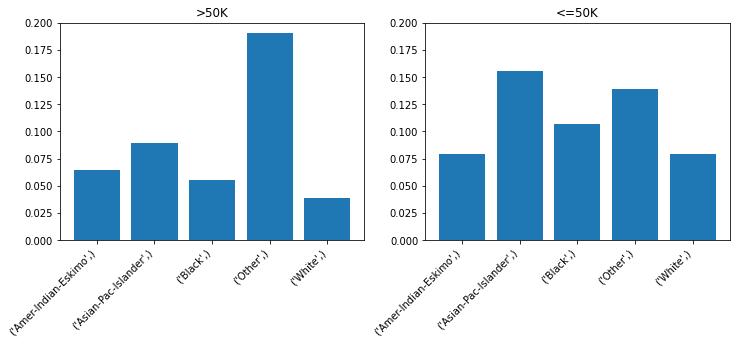

In [7]:
print("Probability of a value with a specific class being removed.")
print("(TODO: Normalize it to lowest probability of being removed?)")
print("Also look at fairness problem definition here: https://arxiv.org/abs/1412.3756")
incomplete_proba = copy.deepcopy(incomplete) # We now calculate this
for label, incomplete_histogram in incomplete_proba.items():
    for group, count in incomplete_histogram.items():
        incomplete_histogram[group] = count / all_records[label][group]
# print(incomplete_proba)

label_with_histogram = list(incomplete_proba.items())[0]
label = label_with_histogram[0]
histogram = label_with_histogram[1]
histogram = collections.OrderedDict(sorted(histogram.items()))
ax1 = pyplot.subplot(1, 2, 1)
keys = [str(key) for key in histogram.keys()] # Necessary because of null values
values = histogram.values()
# values = [value / sum_values for value in values]
pyplot.bar(keys, values)
pyplot.gca().set_title(label)
pyplot.xticks(
    rotation=45,
    horizontalalignment='right',
)
# pyplot.yscale('log')

label_with_histogram = list(incomplete_proba.items())[1]
label = label_with_histogram[0]
histogram = label_with_histogram[1]
histogram = collections.OrderedDict(sorted(histogram.items()))
ax2 = pyplot.subplot(1, 2, 2, sharey=ax1)
keys = [str(key) for key in histogram.keys()] # Necessary because of null values
values = histogram.values()
# values = [value / sum_values for value in values]
pyplot.bar(keys, values)
pyplot.gca().set_title(label)
pyplot.xticks(
    rotation=45,
    horizontalalignment='right',
)
# pyplot.yscale('log')
fig = pyplot.gcf()
fig.set_size_inches(12, 4)
pyplot.show()
pyplot.close()

In [8]:
no_bias_check_result = check_results[NoBiasIntroducedFor(["race", "sex"])]

distribution_changes_overview_df = NoBiasIntroducedFor.get_distribution_changes_overview_as_df(no_bias_check_result)
display(distribution_changes_overview_df)

dag_node_distribution_changes_list = list(no_bias_check_result.bias_distribution_change.items())

,operator_type,description,code_reference,source_code,module,'race' distribution change below the configured minimum test threshold,'race' probability difference above the configured maximum test threshold,'sex' distribution change below the configured minimum test threshold,'sex' probability difference above the configured maximum test threshold
0,OperatorType.SELECTION,dropna,"CodeReference(lineno=29, col_offset=13, end_lineno=29, end_col_offset=36)",raw_train_data.dropna(),"(pandas.core.frame, dropna)",False,True,False,False
1,OperatorType.SELECTION,dropna,"CodeReference(lineno=30, col_offset=12, end_lineno=30, end_col_offset=30)",test_data.dropna(),"(pandas.core.frame, dropna)",False,True,False,False


# Step 4/4 Detailed Investigation

Now that we know of the potential issue, we will take a look at the histograms before and after the JOIN. We can use `distribution_change.before_and_after_df` to look at the data in form of a `pandas.DataFrame` or use the mlinspect utility function `plot_distribution_change_histograms(...)` to plot the histograms. 

OperatorType.SELECTION: raw_train_data.dropna()

 Column 'race', acceptable change: True, min_relative_ratio_change: -0.07491386946359131


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change,removed_records,removal_probability,normed_removal_probability
0,Amer-Indian-Eskimo,258,238,0.009322,0.009295,-0.002946,20,0.077519,1.127156
1,Asian-Pac-Islander,901,776,0.032555,0.030305,-0.069110,125,0.138735,2.017246
2,Black,2660,2393,0.096112,0.093455,-0.027650,267,0.100376,1.459497
3,Other,229,196,0.008274,0.007654,-0.074914,33,0.144105,2.095328
4,White,23628,22003,0.853736,0.859291,0.006506,1625,0.068774,1.000000


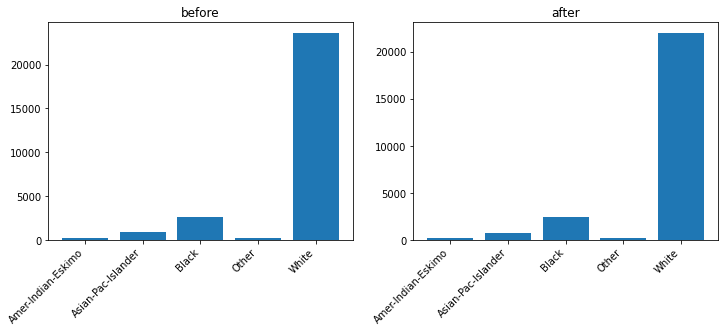

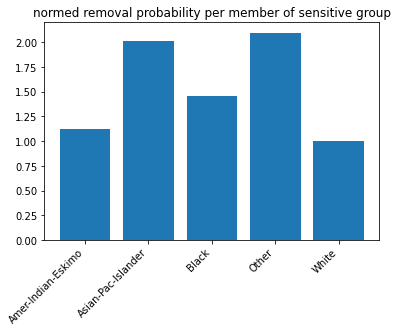


 Column 'sex', acceptable change: True, min_relative_ratio_change: -0.019850243771754417


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change,removed_records,removal_probability,normed_removal_probability
0,Female,9210,8352,0.332779,0.326174,-0.01985,858,0.093160,1.419377
1,Male,18466,17254,0.667221,0.673826,0.00990,1212,0.065634,1.000000


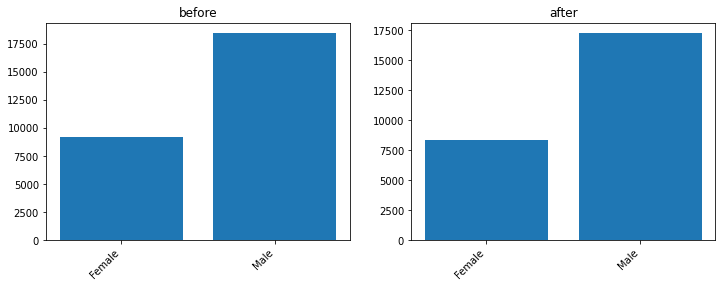

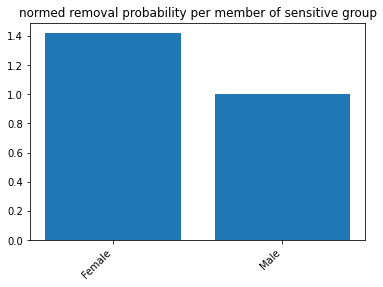

In [9]:
# Select the DagNode we want to look at by index
dag_node, node_distribution_changes = dag_node_distribution_changes_list[0]
# TODO: Out of range because there currently is only one value that changes the distribution: 
#  The imputation. But the imputation doesn't operate on a sensitive attribute.

# Investige the changes
print("\033[1m{}: {}\033[0m".format(dag_node.operator_type, dag_node.source_code))
for column, distribution_change in node_distribution_changes.items():
    print("")
    print("\033[1m Column '{}'\033[0m, acceptable change: {}, min_relative_ratio_change: {}".format(column, distribution_change.acceptable_change, distribution_change.min_relative_ratio_change))
    display(distribution_change.before_and_after_df)
    NoBiasIntroducedFor.plot_distribution_change_histograms(distribution_change)
    NoBiasIntroducedFor.plot_removal_probability_histograms(distribution_change)

# Solution: Did we find operators that introduce bias? How did the distribution of demographic groups change?

**My anser:** The join filters a lot of data points with `sex=Female`. This is because there are a lot of missing join keys in one of the datasets, but only for one of the two demograhpic groups in our example. As a workaround, we could, e.g., consider using an outer join instead of an inner join.

In [10]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

from mlinspect import OperatorType

extracted_dag = inspector_result.dag
inspection_results = inspector_result.inspection_to_annotations
lineage_inspection_result = inspection_results[RowLineage(5)]

relevant_nodes = [node for node in extracted_dag.nodes if node.operator_type in {OperatorType.DATA_SOURCE, OperatorType.GROUP_BY_AGG, OperatorType.CONCATENATION}]

#print(lineage_inspection_result)
for dag_node in relevant_nodes:
    if dag_node in lineage_inspection_result: #and lineage_inspection_result[dag_node] is not None:
        print("\n\033[1m{} ({})\033[0m\n{}\n{}".format(
            dag_node.operator_type, dag_node.description, dag_node.source_code, dag_node.code_reference))
        print("\033[1mFirst output row:\033[0m")
        display(lineage_inspection_result[dag_node].head(1))


OperatorType.DATA_SOURCE (adult_demo_train.csv)
pd.read_csv(train_file, na_values='?', index_col=0)
CodeReference(lineno=18, col_offset=17, end_lineno=18, end_col_offset=68)
First output row:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year,mlinspect_lineage
0,33,Private,135312,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,>50K,"{LineageId(operator_id=0, row_id=0)}"



OperatorType.DATA_SOURCE (adult_demo_test.csv)
pd.read_csv(test_file, na_values='?', index_col=0)
CodeReference(lineno=20, col_offset=12, end_lineno=20, end_col_offset=62)
First output row:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year,mlinspect_lineage
0,23,Private,275244,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,Black,Male,0,0,35,United-States,<=50K,"{LineageId(operator_id=1, row_id=0)}"



OperatorType.CONCATENATION (None)
ColumnTransformer(transformers=[
        ('categorical', nested_categorical_feature_transformation, ['education', 'workclass']),
        ('numeric', StandardScaler(), ['age', 'hours-per-week'])
    ])
CodeReference(lineno=40, col_offset=32, end_lineno=43, end_col_offset=6)
First output row:


,array,mlinspect_lineage
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -0.4152553014930328, -0.07792124097705128]","{LineageId(operator_id=0, row_id=0)}"
